In [1]:
#behavioral performance figures (Fig 4, 5, Supp 2)

import torch
import sys
import os
import io
import json
from os.path import exists
import pickle

import numpy as np
from scipy.special import softmax
from scipy.stats import ranksums, wilcoxon, kstest, ttest_ind
from scipy import stats
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

from dynamics.utils import utils
from dynamics.vis import dynamics as dyplot
from dynamics.process.rnn import wt_kindergarten, wt_nets, wt_costs, wt_reinforce_cont_new, wt_pred, parse
from dynamics.vis import wt_vis
from dynamics.analysis import wt_analysis as wta


#remove
#import glob
#import warnings
#import statsmodels.api as sm

%load_ext autoreload
%autoreload 2
#%matplotlib notebook
#%matplotlib widget 
#out = widgets.Output(layout = widgets.Layout(height='300px'))

In [2]:
#path info

#cluster
#savedir = '/scratch/dh148/dynamics/results/rnn/ac/20231003/figs/'

#local
savedir = '/Users/dhocker/projects/kind_cl/data/processed4plots/'

# for figure 3
subdirlist = ['full_cl/', 'nok_cl/','nok_nocl/',
              'pkind_mem/', 'pkind_count/', 'pkind_int/', 'pkind_pred/',
             'wkind/','wokind/', 
              'nok_nocl_wreg/', 'nok_nocl_longsim/', 'pkind2_mem_inf/', 'gen_kind/','gen_kind_newreg/',
              'pkind3_mem_inf_count/','pkind3_mem_inf_int/', 'gen_kind_lowreg/','onehot/',
              'gen_kind_highreg/','genkind_indlosskind/','onehot_newreg/',
             'L50/', 'L100/','L500/','L1000/','L1000_mem100/',
             'inferencefirst/', 'shortinference/','nok_nocl_longsim/','gru/']

#index withint final trainign stage to grab data
kuse = [10,60,40,
        20,20,20,20,
        10,10, 
        40, 100, 40, 20, 20,
        40, 40, 20, 20, 
        0, 0, 0, 0, 0, 0, 0, 0,
       10, 10, 100, 
        10] 

# number of RNNs per training type, by sidx
num_rnns = {0:50, 1:50, 2:20, 3:20, 4:10, 5:10, 6:10, 7:10, 8:10, 9:10, 10:10, 11:20,
           12:10, 13:10, 14:20, 15:20, 16:10, 17:10,
           26:10, 27:10, 28:5, 29:50}  



In [3]:
# decide on figure

#fig2do = '3'  # full, nok_cl, nok_nocl. Figure 4
#fig2do = 's3'  # single kindergarten. Figure 5a
#fig2do = 'pkind3'  # multi-task kinderaten. Figure 5b
fig2do = '5'  # sham tasks (one-hot). Figure 5c
#fig2do = 's3_wreg'  # regularization only. Figure 5d
#fig2do = 'gen_kind'  #generic kindergarten. Supp fig. 2g-h
#fig2do = 'inf_manip'  # inference manipulations (short inference, inference first). Supp fig 2d-e

klist_dict = {'3': [0,1,2], 's3':[0,3,4,5,6], '5':[0,7,8], 's3_wreg': [0,1,9],
               'pkind3': [0,11,14,15],'gen_kind':[0,1,8,9,13], 'inf_manip': [0,26, 27]}

labs = [k.strip('/') for k in subdirlist]
labs_fig = np.array(labs)[klist_dict[fig2do]]

#select averaging function
uf = np.nanmean
#uf = np.nanmedian

klist = klist_dict[fig2do]


In [4]:
#load files based on klist

#TODO: nok_nocl has been saved wrong here

rr_means_all = []
rr_sems_all = []
rr_sampsforstats = []
print(klist)
print(fig2do)



for s_idx in klist:
    with open(savedir+'rrate_sidx_'+str(s_idx)+'.dat', 'rb') as f:
        tmp =  pickle.load(f)
        rr_means_all.append(tmp[0])
        rr_sems_all.append(tmp[1])
        rr_sampsforstats.append(tmp[2])



[0, 7, 8]
5


In [5]:
# statistics for reward rate at end of training
print(fig2do)
nk = len(klist)

for i in range(nk-1):
    for j in range(i+1,nk):
        print('rank sum: '+labs[klist[i]] + 'vs. ' + labs[klist[j]])
        print(ranksums(rr_sampsforstats[i],rr_sampsforstats[j]))
        print('')

5
rank sum: full_clvs. wkind
RanksumsResult(statistic=2.646599666726792, pvalue=0.008130554214926861)

rank sum: full_clvs. wokind
RanksumsResult(statistic=3.7474923396141038, pvalue=0.0001786112897923331)

rank sum: wkindvs. wokind
RanksumsResult(statistic=2.041241452319315, pvalue=0.041226833337163676)



In [14]:
# check number of networks
for j in range(len(klist)):
    print(len(rr_sampsforstats[j]))

49
10
9


3
['full_cl' 'wkind' 'wokind']


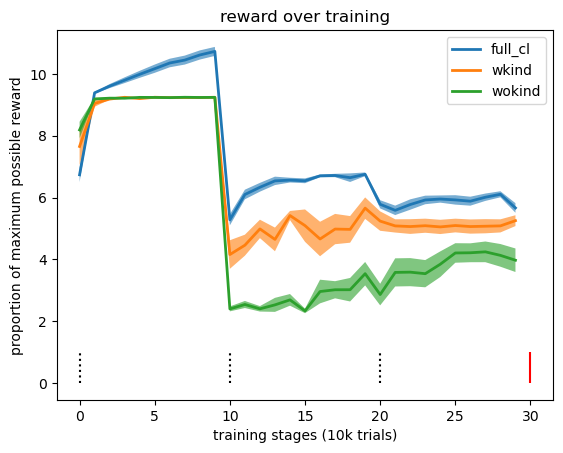

In [15]:
# plot behavior
nk = len(rr_means_all)
print(nk)

nlist = [len(rr_means_all[k]) for k in range(nk)]

print(labs_fig)

for k in range(nk):
    plt.fill_between(range(nlist[k]),np.array(rr_means_all[k])+np.array(rr_sems_all[k]) , 
                     np.array(rr_means_all[k])-np.array(rr_sems_all[k]), alpha = 0.6)
    plt.plot(range(nlist[k]),rr_means_all[k], linewidth=2, label=labs_fig[k])


[plt.vlines(k,0,1.0, linestyle='dotted', color = 'k') for k in [0,10,20] ]
plt.vlines(30,0,1.0, color = 'r',linestyle = 'solid')
plt.xlabel('training stages (10k trials)')
plt.ylabel('proportion of maximum possible reward')
plt.title('reward over training')

plt.legend()

#plt.savefig(savedir+'reward_overtraining_allcl'+fig2do+'.pdf')

plt.show()

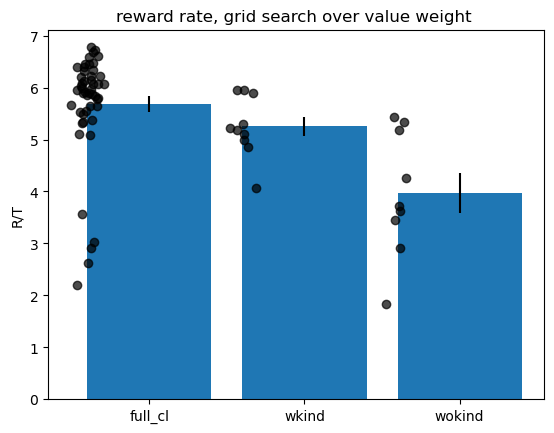

In [17]:
#A,  inset:  reward rate per CL type

npts = len(rr_sampsforstats[0])
r1_jitter = np.random.randn(npts)/25-0.40

npts2 = len(rr_sampsforstats[1])
r2_jitter = np.random.randn(npts2)/25+0.60

npts3 = len(rr_sampsforstats[2])
r3_jitter = np.random.randn(npts3)/25+1.60


rr_means = [np.nanmean(rr_sampsforstats[k]) for k in range(nk)]
rr_sems = [np.nanstd(rr_sampsforstats[k])/np.sqrt(len(rr_sampsforstats[k])) for k in range(nk)]

fig = plt.figure()
plt.bar(range(nk),rr_means)
plt.errorbar(range(nk), rr_means, rr_sems, color = 'k', linestyle = 'none')
plt.scatter(r1_jitter, rr_sampsforstats[0], color = 'k', alpha=0.7)
plt.scatter(r2_jitter, rr_sampsforstats[1], color = 'k', alpha=0.7)
plt.scatter(r3_jitter, rr_sampsforstats[2], color = 'k', alpha=0.7)
plt.ylabel('R/T')
plt.title('reward rate, grid search over value weight ')
plt.xticks(range(nk), labels=labs_fig)


fig.savefig(savedir+'cl_rr_bar_'+fig2do+'.pdf')
plt.show()
#plt.ylim(0.25,0.35)


In [10]:
# load
print(klist)
print(fig2do)


lenlist = []
slopelist = []
optoutlist = []
ratiolist = []
stagelist = []
blockcoefflist = []

for s_idx in klist:
    with open(savedir + 'behdat_sidx_'+str(s_idx)+'.dat', 'rb') as f:
        tmp =  pickle.load(f)
        lenlist.append(tmp[0])
        slopelist.append(tmp[1])
        optoutlist.append(tmp[2])
        ratiolist.append(tmp[3])
        stagelist.append(tmp[4])
        blockcoefflist.append(tmp[5])

[0, 1, 2]
3


In [11]:
# remove outside >95% CI

slopelist_mask = []
optoutlist_mask = []
ratiolist_mask = []
blockcoefflist_mask = []

nk = len(klist)

for k in range(nk):
    #slopes
    n_n, nx = slopelist[k].shape
    test = np.array(slopelist[k])
    test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
    maskout = np.array(test2 > 90)
    slopelist_mask_k = test
    slopelist_mask_k[maskout] = np.nan
    slopelist_mask.append(slopelist_mask_k)
    
    #optouts
    n_n, nx = optoutlist[k].shape
    test = np.array(optoutlist[k])
    test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
    maskout = np.array(test2 > 90)
    optoutlist_mask_k = test
    optoutlist_mask_k[maskout] = np.nan
    optoutlist_mask.append(optoutlist_mask_k)
    
    #wt ratios
    n_n, nx = ratiolist[k].shape
    test = np.array(ratiolist[k])
    test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
    maskout = np.array(test2 > 90)
    ratiolist_mask_k = test
    ratiolist_mask_k[maskout] = np.nan
    ratiolist_mask.append(ratiolist_mask_k)
    
    #block coeff
    n_n, nx = blockcoefflist[k].shape
    test = np.array(blockcoefflist[k])
    test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
    maskout = np.array(test2 > 90)
    blockcoefflist_mask_k = test
    blockcoefflist_mask_k[maskout] = np.nan
    blockcoefflist_mask.append(blockcoefflist_mask_k)


80


/var/folders/c4/ykbrg7ls1_bbwq7_pwvytxjh0000gn/T/ipykernel_1133/3297803869.py:21: RuntimeWarning: Mean of empty slice
  ratiomean = fun(ratiolist_mask[k], axis=0)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/c4/ykbrg7ls1_bbwq7_pwvytxjh0000gn/T/ipykernel_1133/3297803869.py:23: RuntimeWarning: Mean of empty slice
  blockcoeffmean = fun(blockcoefflist_mask[k], axis=0)
/var/folders/c4/ykbrg7ls1_bbwq7_pwvytxjh0000gn/T/ipykernel_1133/3297803869.py:17: RuntimeWarning: Mean of empty slice
  slopemean = fun(slopelist_mask[k], axis=0)
/var/folders/c4/ykbrg7ls1_bbwq7_pwvytxjh0000gn/T/ipykernel_1133/3297803869.py:19: RuntimeWarning: Mean of empty slice
  optoutmean = fun(optoutlist_mask[k], axis=0)


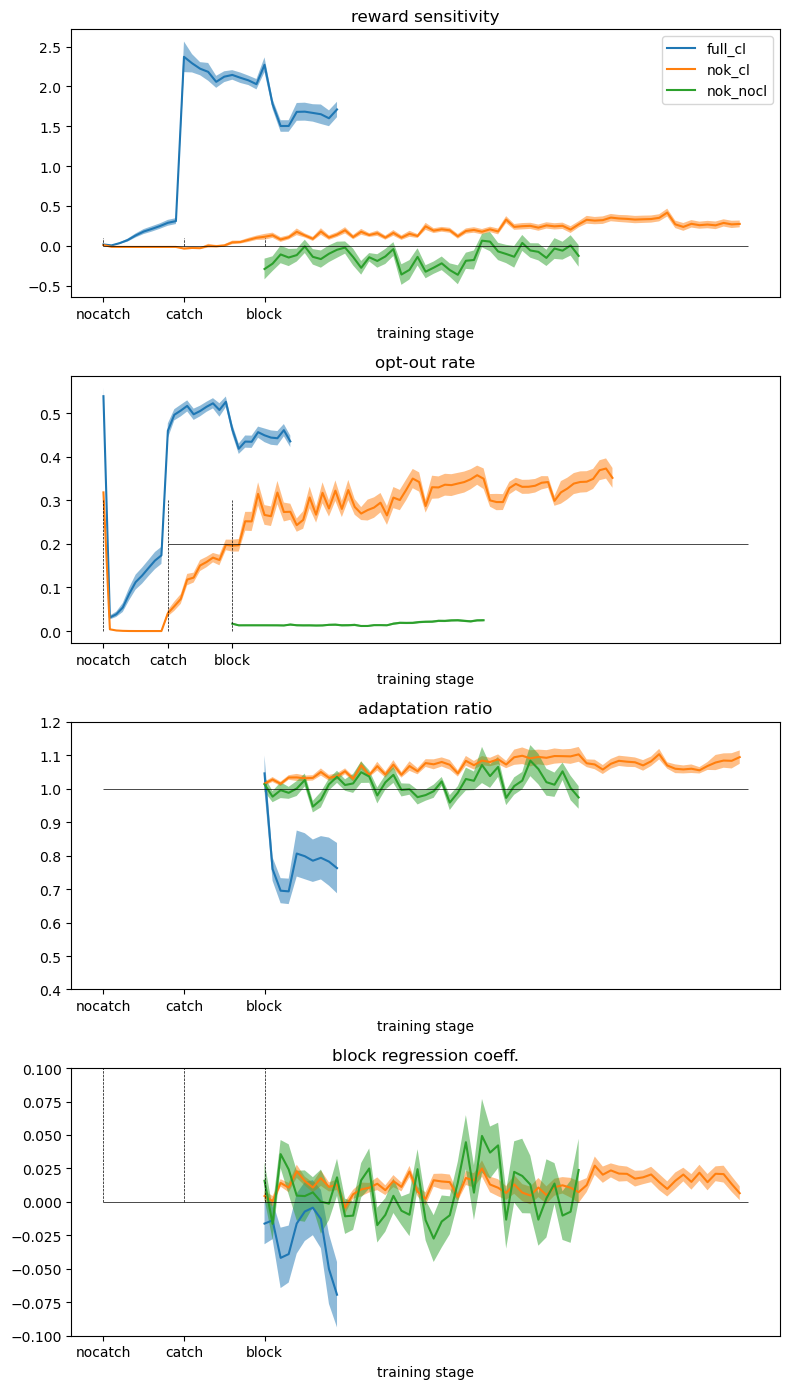

In [12]:
# plot everything

fun = np.nanmean

# plot
fig,ax = plt.subplots(4,1,figsize = (8,14))

allmax = max([max(lenlist[k]) for k in range(nk)])
print(allmax)

for k in range(nk):
    lmax = max(lenlist[k])
    n = num_rnns[klist[k]]
    #print(n)


    slopemean = fun(slopelist_mask[k], axis=0)
    slopesem = np.nanstd(slopelist_mask[k], axis=0)/np.sqrt(n)
    optoutmean = fun(optoutlist_mask[k], axis=0)
    optoutsem = np.nanstd(optoutlist_mask[k], axis=0)/np.sqrt(n)
    ratiomean = fun(ratiolist_mask[k], axis=0)
    ratiosem = np.nanstd(ratiolist_mask[k], axis=0)/np.sqrt(n)
    blockcoeffmean = fun(blockcoefflist_mask[k], axis=0)
    blockcoeffsem = np.nanstd(blockcoefflist_mask[k], axis=0)/np.sqrt(n)
    
    ax[0].plot(range(lmax),slopemean, label = labs_fig[k])
    ax[0].fill_between(range(lmax),slopemean-slopesem, slopemean+slopesem, alpha = 0.5)

    ax[1].plot(range(lmax),optoutmean)
    ax[1].fill_between(range(lmax),optoutmean-optoutsem, optoutmean+optoutsem, alpha = 0.5)

    ax[2].plot(range(lmax),ratiomean)
    ax[2].fill_between(range(lmax),ratiomean-ratiosem, ratiomean+ratiosem, alpha = 0.5) 

    ax[3].plot(range(lmax),blockcoeffmean)
    ax[3].fill_between(range(lmax),blockcoeffmean-blockcoeffsem, blockcoeffmean+blockcoeffsem, alpha = 0.5)


ax[0].hlines(0.0, 0,allmax, color = 'k', linewidth = 0.5)  
ax[1].hlines(0.2, 10,20+allmax, color = 'k', linewidth = 0.5)
ax[2].hlines(1.0, 0,allmax, color = 'k', linewidth = 0.5)
ax[3].hlines(0.0, 0,allmax, color = 'k', linewidth = 0.5)
    
if fig2do == '3':
    ax[2].set_ylim([0.4,1.2])
else:
    ax[2].set_ylim([0.4,1.4])
if fig2do == '3':
    ax[3].set_ylim([-0.1,0.1])
elif fig2do == '5':
    ax[3].set_ylim([-0.15,0.15])
    
ax[0].legend()


#find a completed network and grab its stagelist
#stagelist = stagelist_list[np.argmax(lenlist_nok_cl)]
stagedict = {0:'simple', 1:'int', 2:'pred', 3:'nocatch', 4:'catch', 5:'block', 6:'freeze'}
typeloc = [np.argwhere(stagelist[0][0] == k)[0,0] for k in np.unique(stagelist[0][0]) ]

for j in range(4):
    if j > 0:
        [ax[j].vlines(k,  0, 0.3, color='k',linewidth = 0.5, linestyle = 'dashed') for k in typeloc]
    else:
        [ax[j].vlines(k,  0, 0.1, color='k',linewidth = 0.5, linestyle = 'dashed') for k in typeloc]
    ax[j].set_xticks(typeloc, labels = [stagedict[stagelist[0][0][k]] for k in typeloc], rotation = 0)
    ax[j].set_xlabel('training stage')
    #ax[j].set_ylabel('wt slope')

#[ax[2].vlines(k-0.5,  0.5, 1.2, color='k',linewidth = 0.5, linestyle = 'dashed') for k in typeloc]


ax[0].set_title('reward sensitivity')
ax[1].set_title('opt-out rate')
ax[2].set_title('adaptation ratio')
ax[3].set_title('block regression coeff.')

plt.tight_layout()

#plt.savefig(savedir+'beh_'+fig2do+'.pdf')
plt.show()


In [13]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`

    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

number of networks:0
[49, 49, 49]
number of networks:1
[47, 47, 47]
number of networks:2
[18, 18, 18]


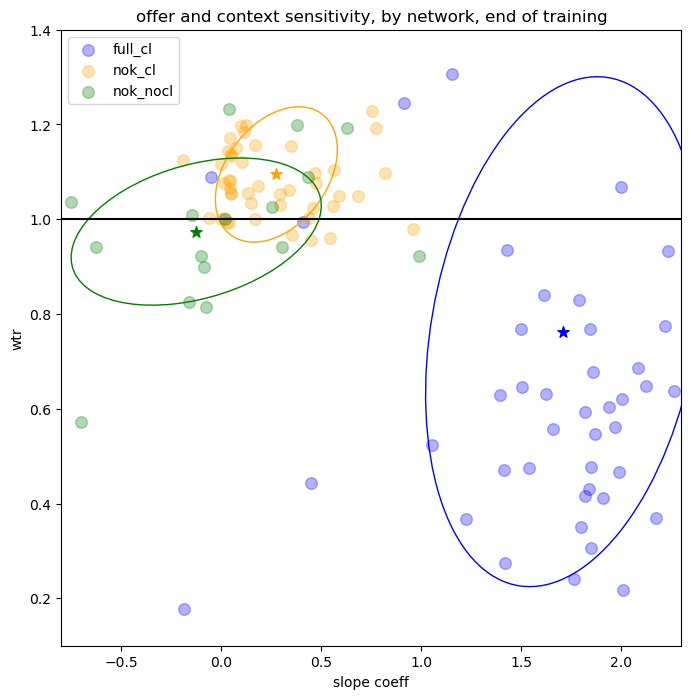

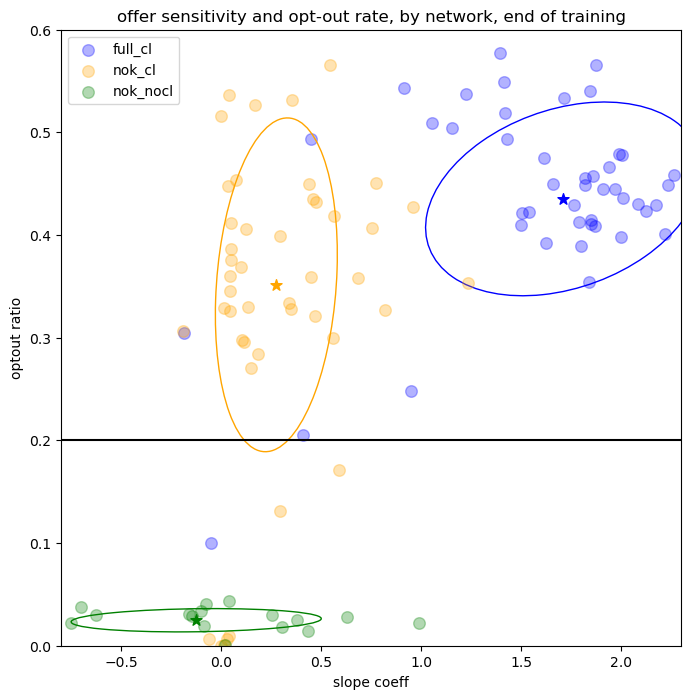

In [14]:
# scatter plot of slope vs. adaptation ratio



#TODO: set xlim and ylim values for each plot type

#lims_offer = {'3':[-0.015,0.07], 's3':[-0.015,0.07], '5':[-0.015,0.07], 's3_pkind2':[-np.inf,np.inf],
#            's3_wreg':[-0.015,0.07], 'pkind3':[-0.015,0.07], 'gen_kind':[-0.015,0.07], 'onehot':[-np.inf,np.inf],
#             'inf_manip':[-0.015,0.07]}
lims_offer = {'3':[-0.8,2.3], 's3':[-0.8,2.3], '5':[-0.8,2.3], 's3_pkind2':[-0.8,2.3],
            's3_wreg':[-0.8,2.3], 'pkind3':[-0.8,2.3], 'gen_kind':[-0.8,2.3], 'onehot':[-0.8,2.3],
             'inf_manip':[-1.5,2.3]}



lims_wtr = {'3':[0.1,1.4], 's3':[0.0,1.7], '5':[0.0,1.8], 's3_pkind2':[-np.inf,np.inf],
            's3_wreg':[0.1,3.5], 'pkind3':[0.1,1.7], 'gen_kind':[0.1,2.0], 'onehot':[-np.inf,np.inf],
           'inf_manip':[0, 2]}

lims_optout = {'3':[0,0.6], 's3':[0,0.6], '5':[0,0.6], 's3_pkind2':[-np.inf,np.inf],
            's3_wreg':[0,0.6], 'pkind3':[0,0.6], 'gen_kind':[0,1], 'onehot':[-np.inf,np.inf],
              'inf_manip':[0, 1]}


colors = ['blue','orange','green','red','purple','brown']


fig = plt.figure(figsize=(8,8))
ax = plt.gca()

for k in range(nk):
    
    slopes_full_scatter = np.array([k[-1] for k in slopelist_mask[k]])
    wtr_full_scatter = np.array([k[-1] for k in ratiolist_mask[k]])
    optout_full_scatter = np.array([k[-1] for k in optoutlist_mask[k]])
    
    good_idx = (~np.isnan(slopes_full_scatter)) & (~np.isnan(wtr_full_scatter))
    slopes_full_scatter = slopes_full_scatter[good_idx]
    wtr_full_scatter = wtr_full_scatter[good_idx]
    
    plt.scatter(slopes_full_scatter,wtr_full_scatter ,s=70,label=labs_fig[k],color=colors[k], alpha=0.3,linewidth=None)
    
    print('number of networks:' +str(k))
    print([np.sum(~np.isnan(slopes_full_scatter)),
           np.sum(~np.isnan(wtr_full_scatter)), 
           np.sum(~np.isnan(optout_full_scatter))])
    #plt.hlines(np.nanmean(wtr_full_scatter),lims_offer[fig2do][0],lims_offer[fig2do][1],color=colors[k],linestyle='dotted')
    #plt.vlines(np.nanmean(slopes_full_scatter),lims_wtr[fig2do][0],lims_wtr[fig2do][1],color=colors[k],linestyle='dotted')
    
    # add oval
    ellipse_means = (np.nanmean(slopes_full_scatter),np.nanmean(wtr_full_scatter))
    #ellipse_width = 1.96*np.nanstd(slopes_full_scatter)
    #ellipse_height = 1.96*np.nanstd(wtr_full_scatter)
    #ellipse = Ellipse(xy=ellipse_means, width=ellipse_width, height=ellipse_height, 
    #                    edgecolor=colors[k], fc='None', lw=2)
    #ax.add_patch(ellipse)
    plt.scatter(ellipse_means[0],ellipse_means[1],s=70,marker='*',color=colors[k])
    
    confidence_ellipse(slopes_full_scatter, wtr_full_scatter, ax, edgecolor=colors[k],n_std=1.0)

    
plt.hlines(1.0, lims_offer[fig2do][0],lims_offer[fig2do][1],color='k')
plt.xlabel('slope coeff')
plt.ylabel('wtr')
plt.title('offer and context sensitivity, by network, end of training')
plt.legend()
plt.xlim(lims_offer[fig2do][0], lims_offer[fig2do][1])
plt.ylim(lims_wtr[fig2do][0], lims_wtr[fig2do][1])
fig.savefig(savedir+'scatter_wtr_'+str(fig2do)+'.pdf')
plt.show()


fig = plt.figure(figsize=(8,8))
ax = plt.gca()

for k in range(nk):
    slopes_full_scatter = np.array([k[-1] for k in slopelist_mask[k]])
    optout_full_scatter = np.array([k[-1] for k in optoutlist_mask[k]])
    
    good_idx = (~np.isnan(slopes_full_scatter)) & (~np.isnan(optout_full_scatter))
    slopes_full_scatter = slopes_full_scatter[good_idx]
    optout_full_scatter = optout_full_scatter[good_idx]

    plt.scatter(slopes_full_scatter,optout_full_scatter ,s=70,label=labs_fig[k],color=colors[k],alpha=0.3,linewidth=None)
    #plt.vlines(np.nanmean(slopes_full_scatter),lims_optout[fig2do][0],lims_optout[fig2do][1],color=colors[k],linestyle='dotted')
    #plt.hlines(np.nanmean(optout_full_scatter),lims_offer[fig2do][0],lims_offer[fig2do][1],color=colors[k],linestyle='dotted')
    
    # add ovals
    ellipse_means = (np.nanmean(slopes_full_scatter),np.nanmean(optout_full_scatter))
    #ellipse_width = 1.96*np.nanstd(slopes_full_scatter)
    #ellipse_height = 1.96*np.nanstd(optout_full_scatter)
    #ellipse = Ellipse(xy=ellipse_means, width=ellipse_width, height=ellipse_height, 
    #                    edgecolor=colors[k], fc='None', lw=2)
    #ax.add_patch(ellipse)
    plt.scatter(ellipse_means[0],ellipse_means[1],s=70,marker='*',color=colors[k])
    confidence_ellipse(slopes_full_scatter, optout_full_scatter, ax, edgecolor=colors[k],n_std=1.0)
    
        
plt.hlines(0.2, lims_offer[fig2do][0],lims_offer[fig2do][1],color='k')
plt.xlabel('slope coeff')
plt.ylabel('optout ratio')
plt.title('offer sensitivity and opt-out rate, by network, end of training')
plt.legend()
plt.xlim(lims_offer[fig2do][0], lims_offer[fig2do][1])
plt.ylim(lims_optout[fig2do][0], lims_optout[fig2do][1])
#fig.savefig(savedir+'scatter_optout_'+str(fig2do)+'.pdf')
plt.show()




In [15]:
# do statistical tests to check if normal

slopes = []

for k in range(nk):
    slopes_full_scatter = np.array([k[-1] for k in slopelist_mask[k]])
    slopes.append(slopes_full_scatter)
    
    
for i in range(nk-1):
    for j in range(i+1,nk):
        #test = ranksums(slopes[i],slopes[j])
        #print('ranksum for slopes: '+labs_fig[i]+', '+labs_fig[j])
        
        test = ttest_ind(slopes[i], slopes[j],nan_policy='omit')
        print('t test for slopes: '+labs_fig[i]+', '+labs_fig[j])
        print(test)
        

t test for slopes: full_cl, nok_cl
TtestResult(statistic=13.098717287988778, pvalue=6.408349834595246e-23, df=94.0)
t test for slopes: full_cl, nok_nocl
TtestResult(statistic=9.896307453899858, pvalue=1.3464736492986863e-14, df=65.0)
t test for slopes: nok_cl, nok_nocl
TtestResult(statistic=3.471361838703791, pvalue=0.000940766929192302, df=63.0)


In [16]:
# for wait time ratio
wtrs = []

for k in range(nk):
    wtr_full_scatter = np.array([k[-1] for k in ratiolist_mask[k]])
    wtrs.append(wtr_full_scatter)
    
    
for i in range(nk-1):
    for j in range(i+1,nk):
        #test = ranksums(wtrs[i],wtrs[j])
        #print('ranksum for wtr: '+labs_fig[i]+', '+labs_fig[j])
        #print(test)
        
        test = ttest_ind(wtrs[i],wtrs[j],nan_policy='omit')
        print('t test for wtr: '+labs_fig[i]+', '+labs_fig[j])
        print(test)

t test for wtr: full_cl, nok_cl
TtestResult(statistic=-4.090464134739924, pvalue=9.083517303828821e-05, df=94.0)
t test for wtr: full_cl, nok_nocl
TtestResult(statistic=-1.6333085113344832, pvalue=0.10723925142054128, df=65.0)
t test for wtr: nok_cl, nok_nocl
TtestResult(statistic=2.973289316096839, pvalue=0.004170516894850868, df=63.0)


In [17]:
# for opt-out rate

optouts = []

for k in range(nk):
    optout_full_scatter = np.array([k[-1] for k in optoutlist_mask[k]])
    optouts.append(optout_full_scatter)
    
    
for i in range(nk-1):
    for j in range(i+1,nk):
        #test = ranksums(optouts[i],optouts[j])
        #print('ranksum for optout: '+labs_fig[i]+', '+labs_fig[j])
        #print(test)
        
        test = ttest_ind(optouts[i],optouts[j],nan_policy='omit')
        print('t test for optout: '+labs_fig[i]+', '+labs_fig[j])
        print(test)

t test for optout: full_cl, nok_cl
TtestResult(statistic=3.1012654896048946, pvalue=0.0025438130504213835, df=94.0)
t test for optout: full_cl, nok_nocl
TtestResult(statistic=18.319793530466054, pvalue=2.301786120615846e-27, df=65.0)
t test for optout: nok_cl, nok_nocl
TtestResult(statistic=8.478224432678196, pvalue=5.216618838899622e-12, df=63.0)


In [18]:
# are they normally distributed???
print('ks test: slopes')

for idx_ks in range(len(slopelist)):
    print(idx_ks)

    slopes_final = np.array([k[-1] for k in slopelist_mask[idx_ks]])
    slopes_final = slopes_final[~np.isnan(slopes_final)]

    slopes_z = (slopes_final-np.nanmean(slopes_final))/np.nanstd(slopes_final)

    print(kstest(slopes_z, 'norm'))
    
print('opt-out')
for idx_ks in range(len(slopelist)):
    print(idx_ks)

    optout_final = np.array([k[-1] for k in optoutlist_mask[idx_ks]])
    optout_final = optout_final[~np.isnan(optout_final)]

    optout_z = (optout_final-np.nanmean(optout_final))/np.nanstd(optout_final)

    print(kstest(optout_z, 'norm'))
    
print('wtr')
for idx_ks in range(len(slopelist)):
    print(idx_ks)

    wtr_final = np.array([k[-1] for k in ratiolist_mask[idx_ks]])
    wtr_final = wtr_final[~np.isnan(wtr_final)]

    wtr_z = (wtr_final-np.nanmean(wtr_final))/np.nanstd(wtr_final)

    print(kstest(wtr_z, 'norm'))



ks test: slopes
0
KstestResult(statistic=0.13610778676089194, pvalue=0.2965214343632725, statistic_location=-0.4683105677435937, statistic_sign=-1)
1
KstestResult(statistic=0.19322502049044998, pvalue=0.051859170735222504, statistic_location=-0.3022176775096692, statistic_sign=1)
2
KstestResult(statistic=0.19933032683630186, pvalue=0.4173370050361499, statistic_location=-0.05741299793320497, statistic_sign=-1)
opt-out
0
KstestResult(statistic=0.1704382086015846, pvalue=0.10292821046865674, statistic_location=-0.4865310404913786, statistic_sign=-1)
1
KstestResult(statistic=0.17228106812451877, pvalue=0.10883684653056713, statistic_location=-0.34839859218485475, statistic_sign=-1)
2
KstestResult(statistic=0.09991798703347654, pvalue=0.985538171002671, statistic_location=0.2531348283931735, statistic_sign=-1)
wtr
0
KstestResult(statistic=0.1893274032301967, pvalue=0.05185612403029316, statistic_location=-0.1425427480840956, statistic_sign=1)
1
KstestResult(statistic=0.1878967334045497, pv